# EWT LSTM

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense, Dropout, Flatten, Input, Conv1D, MaxPooling1D
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.fft import fft, ifft

2024-11-27 11:44:07.100837: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
import tensorflow as tf
import numpy as np
import random

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
%run utils.ipynb

In [5]:
df_ori = load_data('df_actual_22_24_cleaned')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24840 entries, 2022-01-01 01:00:00 to 2024-11-01 00:00:00
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   price                    24840 non-null  float64
 1   solar                    24840 non-null  int64  
 2   wind_onshore             24840 non-null  int64  
 3   wind_offshore            24840 non-null  int64  
 4   total_load               24840 non-null  int64  
 5   actual_solar             24840 non-null  int64  
 6   actual_wind_onshore      24840 non-null  int64  
 7   actual_wind_offshore     24840 non-null  int64  
 8   actual_fossil_gas        24840 non-null  int64  
 9   actual_fossil_hard_coal  24840 non-null  int64  
dtypes: float64(1), int64(9)
memory usage: 2.1 MB
None


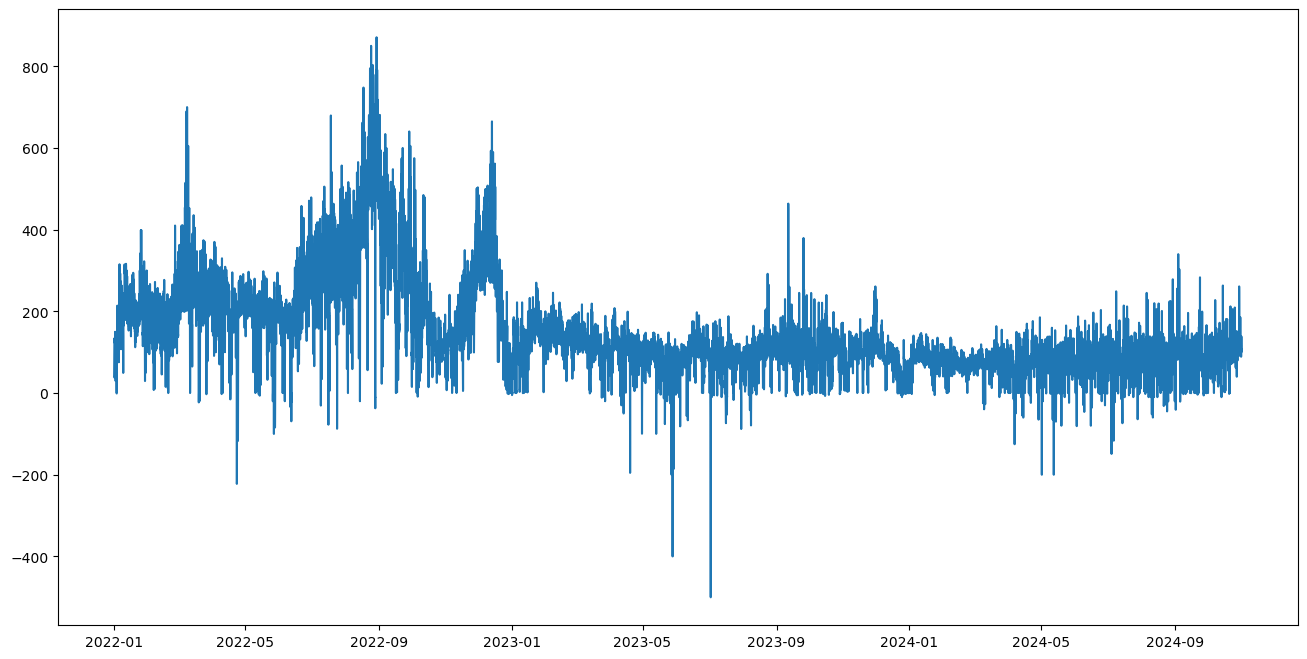

In [6]:
fig= plt.subplots(figsize=(16, 8))
plt.plot(df_ori['price'], label="Original Signal", linewidth=1.5)

# EWT

In [7]:
SEQ = 24

In [8]:
features = ['price'] 
df_ewt = df_ori.loc['2021': '2024',  features]

In [9]:
def train_test_split_th(df, features =['price'], train_period = ['2022', '2023'], test_period = ['2024', '2024']): 
    train_start, train_end = train_period
    test_start, test_end = test_period
    df_ewt = df_ori.loc[train_start: test_end,  features]
    
    train_df = df.loc[train_start: train_end]
    test_df = df.loc[test_start: test_end]

    return train_df, test_df

In [10]:
train_df_ewt, test_df_ewt = train_test_split_th(df_ori, features =['price'], train_period = ['2022', '2023'], test_period =  ['2024', '2024']) 

In [11]:
print('train shape', train_df_ewt.shape)
print('test shape', test_df_ewt.shape)

train shape (17519, 10)
test shape (7321, 10)


In [12]:
def ewt_trans(data, level = 4, lengthFilter=10, reg='none', sigmaFilter=5):

    # return reconstructed signal and components
    sig_combined, sig_comps = ewt_decompose(data, level, lengthFilter= lengthFilter, reg = reg, sigmaFilter = sigmaFilter)
    
    eva_s(data.to_numpy(), sig_combined)
    fig, ax= plt.subplots(figsize=(16, 8))
    plt.plot(data.to_numpy()[:200], label = 'Actual',alpha = 0.7)
    plt.plot(sig_combined[:200], label = 'Simulated', alpha = 0.7)
    ax.legend(loc=2)

    return sig_comps

Mean Absolute Error (MAE): 7.87
Root Mean Squared Error (RMSE): 11.51
Symmetric Mean Absolute Percentage Error (sMAPE): 13.93


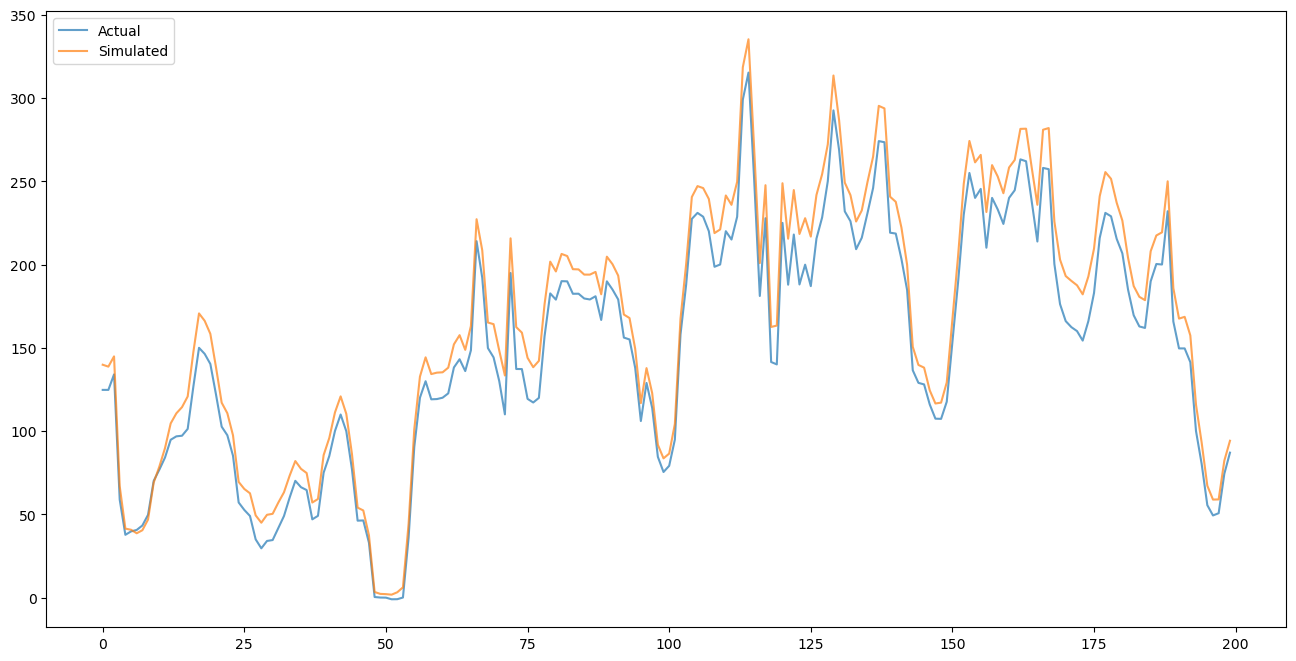

In [13]:
sig_comps = ewt_trans(df_ewt['price'], level = 6, lengthFilter= 1, reg = 'none', sigmaFilter=5)

In [14]:
sig_comps.shape

(24840, 6)

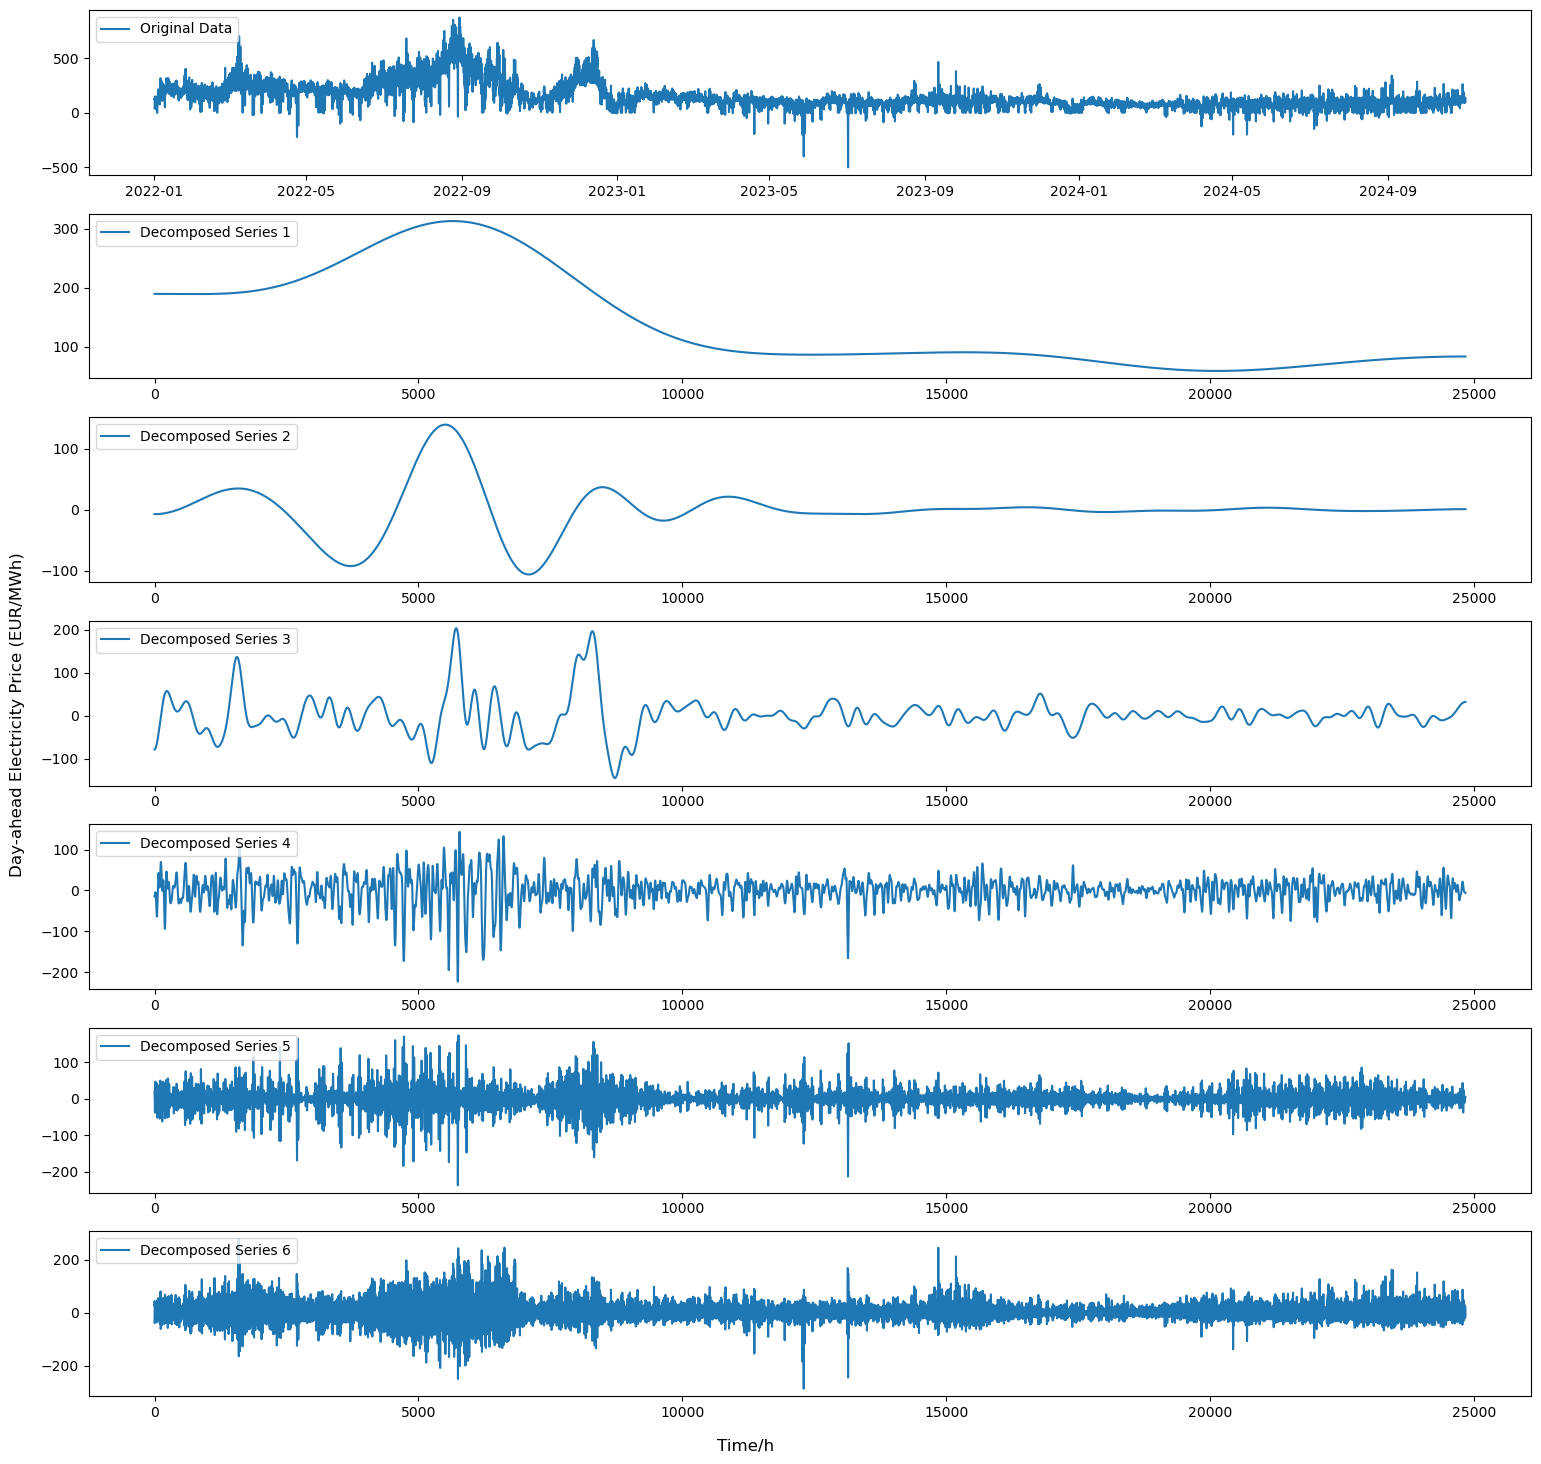

In [18]:
fig, axes= plt.subplots(7,1, figsize=(16, 16))
axes[0].plot(df_ewt, label = 'Original Data')
axes[0].legend(loc=2)
for i in range(sig_comps.shape[1]):
    axes[i+1].plot(sig_comps[:,i], label = f'Decomposed Series {i+1}')
    axes[i + 1].legend(loc=2)

# Add a common ylabel and xlabel for the entire figure
fig.text(0.04, 0.5, 'Day-ahead Electricity Price (EUR/MWh)', va='center', rotation='vertical', fontsize=12)
fig.text(0.5, 0.04, 'Time/h', ha='center', fontsize=12)

# Adjust spacing
plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])
file_name = 'ewt_decompose'
plt.savefig(f'eda_plot/{file_name}.png', dpi=300, bbox_inches="tight") 

## Models

In [15]:
def lstm_model_ewt(train_data, test_data):
    # Step 3: Normalize each component separately
    scaler = MinMaxScaler()
    # train_scaled = scaler.fit_transform(train_data.reshape(-1, 1))
    # test_scaled = scaler.transform(test_data.reshape(-1, 1))
    
    train_scaled = scaler.fit_transform(train_data.reshape(-1, 1))
    test_scaled = scaler.transform(test_data.reshape(-1, 1))
    
    # train_scaled = train_data.reshape(-1, 1)
    
    def create_seq(data, seq_length=24):
        X, y = [], []
        for i in range(len(data) - seq_length):
            X.append(data[i:i + seq_length, :])  # Previous `window_size` steps across all components
            y.append(data[i + seq_length, 0])
    
        return np.array(X), np.array(y)
    
    X_train, y_train = create_seq(train_scaled, 24)
    X_test, y_test = create_seq(test_scaled, 24)# Step 5: Define the LSTM model
    
    model = Sequential([
        Input(shape=(X_train.shape[1], X_train.shape[2])),
        LSTM(units=64, return_sequences=True),
        Dropout(0.2),
        LSTM(units=32, return_sequences=False),
        Dense(units=1)
    ])
    
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    model.summary()

    # Train the model
    history = model.fit(X_train, y_train, epochs=20, batch_size=32)

    print('Predict on X_test.')
    y_pred = model.predict(X_test)
    
    print('Predict on X_train.')
    train_pred = model.predict(X_train)
    # Predict
    y_pred_rescaled = scaler.inverse_transform(y_pred.reshape(-1, 1))
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))
    train_pred_rescaled = scaler.inverse_transform(train_pred.reshape(-1, 1))

    
    mae, rsme, mape = eva_s(y_test_rescaled, y_pred_rescaled)

    y_test_preds = [y_test_rescaled,y_pred_rescaled]
    performance = [mae, rsme, mape]

    return model, y_test_preds, performance, train_pred_rescaled

In [16]:
def gru_model_ewt(train_data, test_data):

    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_data.reshape(-1, 1))
    test_scaled = scaler.transform(test_data.reshape(-1, 1))
    
    def create_seq(data, seq_length=24):
        X, y = [], []
        for i in range(len(data) - seq_length):
            X.append(data[i:i + seq_length, :])  # Previous `window_size` steps across all components
            y.append(data[i + seq_length, 0])
    
        return np.array(X), np.array(y)
    
    X_train, y_train = create_seq(train_scaled, 24)
    X_test, y_test = create_seq(test_scaled, 24)

    # Step 5: Define the GRU model
    model = Sequential([
        Input(shape=(X_train.shape[1], X_train.shape[2])),
        GRU(units=64, return_sequences=True),
        Dropout(0.2),
        GRU(units=32, return_sequences=False),
        Dense(units=1)
    ])
    
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.summary()

    # Train the model
    history = model.fit(X_train, y_train, epochs=20, batch_size=32)

    print('Predict on X_test.')
    y_pred = model.predict(X_test)
    
    print('Predict on X_train.')
    train_pred = model.predict(X_train)

    # Rescale predictions
    y_pred_rescaled = scaler.inverse_transform(y_pred.reshape(-1, 1))
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))
    train_pred_rescaled = scaler.inverse_transform(train_pred.reshape(-1, 1))

    mae, rsme, mape = eva_s(y_test_rescaled, y_pred_rescaled)

    y_test_preds = [y_test_rescaled,y_pred_rescaled]
    performance = [mae, rsme, mape]

    return model, y_test_preds, performance, train_pred_rescaled

In [17]:
def cnn_model_ewt(train_data, test_data):
    
    # Step 3: Normalize each component separately
    scaler = MinMaxScaler()
    # scaler = StandardScaler()
    train_scaled = scaler.fit_transform(train_data.reshape(-1, 1))
    test_scaled = scaler.transform(test_data.reshape(-1, 1))
    
    def create_seq(data, seq_length=24):
        X, y = [], []
        for i in range(len(data) - seq_length):
            X.append(data[i:i + seq_length, :])  # Previous `window_size` steps across all components
            y.append(data[i + seq_length, 0])
    
        return np.array(X), np.array(y)
    
    X_train, y_train = create_seq(train_scaled, 24)
    X_test, y_test = create_seq(test_scaled, 24)

    # Step 5: Define the CNN model
    model = Sequential([
        Input(shape=(X_train.shape[1], X_train.shape[2])),
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        Dropout(0.2),
        Conv1D(filters=32, kernel_size=3, activation='relu'),
        Flatten(),
        Dense(units=1)
    ])
    
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.summary()

    # Train the model
    history = model.fit(X_train, y_train, epochs=20, batch_size=32)

    print('Predict on X_test.')
    y_pred = model.predict(X_test)
    
    print('Predict on X_train.')
    train_pred = model.predict(X_train)

    # Rescale predictions
    y_pred_rescaled = scaler.inverse_transform(y_pred.reshape(-1, 1))
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))
    train_pred_rescaled = scaler.inverse_transform(train_pred.reshape(-1, 1))

    mae, rsme, mape = eva_s(y_test_rescaled, y_pred_rescaled)

    y_test_preds = [y_test_rescaled, y_pred_rescaled]
    performance = [mae, rsme, mape]

    return model, y_test_preds, performance, train_pred_rescaled


In [18]:
def cnn_lstm_model_ewt(train_data, test_data):
    # Step 3: Normalize each component separately
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_data.reshape(-1, 1))
    test_scaled = scaler.transform(test_data.reshape(-1, 1))
    
    def create_seq(data, seq_length=24):
        X, y = [], []
        for i in range(len(data) - seq_length):
            X.append(data[i:i + seq_length, :])  # Previous `seq_length` steps across all components
            y.append(data[i + seq_length, 0])
        return np.array(X), np.array(y)
    
    # Create sequences
    X_train, y_train = create_seq(train_scaled, 24)
    X_test, y_test = create_seq(test_scaled, 24)

    # Step 5: Define the CNN-LSTM model
    model = Sequential([
        Input(shape=(X_train.shape[1], X_train.shape[2])),
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        LSTM(units=64, return_sequences=True),
        Dropout(0.2),
        LSTM(units=32, return_sequences=False),
        Dense(units=1)
    ])
    
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.summary()

    # Train the model
    history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

    print('Predict on X_test.')
    y_pred = model.predict(X_test)
    
    print('Predict on X_train.')
    train_pred = model.predict(X_train)
    
    # Rescale predictions and actual values back to original scale
    y_pred_rescaled = scaler.inverse_transform(y_pred.reshape(-1, 1))
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))
    train_pred_rescaled = scaler.inverse_transform(train_pred.reshape(-1, 1))

    # Evaluate the performance
    mae, rsme, mape = eva_s(y_test_rescaled, y_pred_rescaled)

    y_test_preds = [y_test_rescaled, y_pred_rescaled]
    performance = [mae, rsme, mape]

    return model, y_test_preds, performance, train_pred_rescaled


In [19]:
def cnn_model_ewt_2(train_data, test_data):
    # Step 3: Normalize each component separately
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_data.reshape(-1, 1))
    test_scaled = scaler.transform(test_data.reshape(-1, 1))
    
    def create_seq(data, seq_length=24):
        X, y = [], []
        for i in range(len(data) - seq_length):
            X.append(data[i:i + seq_length, :])  # Previous `seq_length` steps across all components
            y.append(data[i + seq_length, 0])
        return np.array(X), np.array(y)
    
    # Create sequences
    X_train, y_train = create_seq(train_scaled, 24)
    X_test, y_test = create_seq(test_scaled, 24)

    # Step 5: Define the CNN-LSTM model
    model = Sequential([
        Input(shape=(X_train.shape[1], X_train.shape[2])),
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        LSTM(units=64, return_sequences=True),
        Dropout(0.2),
        LSTM(units=32, return_sequences=False),
        Dense(units=1)
    ])
    
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.summary()

    # Train the model
    history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

    print('Predict on X_test.')
    y_pred = model.predict(X_test)
    
    print('Predict on X_train.')
    train_pred = model.predict(X_train)
    
    # Rescale predictions and actual values back to original scale
    y_pred_rescaled = scaler.inverse_transform(y_pred.reshape(-1, 1))
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))
    train_pred_rescaled = scaler.inverse_transform(train_pred.reshape(-1, 1))

    # Evaluate the performance
    mae, rsme, mape = eva_s(y_test_rescaled, y_pred_rescaled)

    y_test_preds = [y_test_rescaled, y_pred_rescaled]
    performance = [mae, rsme, mape]

    return model, y_test_preds, performance, train_pred_rescaled

In [20]:
from keras.models import Model, Sequential
from keras.layers import Input, LSTM, Dense, Dropout, Multiply, Lambda
# from sklearn.preprocessing import MinMaxScaler
import numpy as np
import keras.backend as K

def lstm_am_model_ewt(train_data, test_data):
    # Step 1: Normalize each component separately
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_data.reshape(-1, 1))
    test_scaled = scaler.transform(test_data.reshape(-1, 1))
    
    # Step 2: Create sequences for training and testing
    def create_seq(data, seq_length=24):
        X, y = [], []
        for i in range(len(data) - seq_length):
            X.append(data[i:i + seq_length, :])  # Previous `seq_length` steps
            y.append(data[i + seq_length, 0])   # Target value
        return np.array(X), np.array(y)
    
    X_train, y_train = create_seq(train_scaled, 24)
    X_test, y_test = create_seq(test_scaled, 24)

    # Step 3: Define Attention Layer
    def attention_layer(inputs):
        """
        Attention mechanism to focus on relevant parts of the sequence.
        """
        attention_scores = Dense(1, activation='tanh')(inputs)  # Score for each time step
        attention_scores = Lambda(lambda x: K.softmax(x, axis=1))(attention_scores)  # Normalize scores
        context_vector = Multiply()([inputs, attention_scores])  # Weighted input
        context_vector = Lambda(lambda x: K.sum(x, axis=1))(context_vector)  # Sum over time steps
        return context_vector

    # Step 4: Define the LSTM model with Attention
    inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
    lstm_out = LSTM(64, return_sequences=True)(inputs)  # LSTM layer
    lstm_out = Dropout(0.2)(lstm_out)
    context_vector = attention_layer(lstm_out)  # Apply Attention
    outputs = Dense(1)(context_vector)  # Final Dense layer for prediction
    model = Model(inputs, outputs)
    
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.summary()

    # Step 5: Train the model
    history = model.fit(X_train, y_train, epochs=20, batch_size=32)

    # Step 6: Predict
    print('Predict on X_test.')
    y_pred = model.predict(X_test)
    
    print('Predict on X_train.')
    train_pred = model.predict(X_train)

    # Step 7: Rescale predictions back to original scale
    y_pred_rescaled = scaler.inverse_transform(y_pred.reshape(-1, 1))
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))
    train_pred_rescaled = scaler.inverse_transform(train_pred.reshape(-1, 1))

    # Step 8: Evaluate the performance
    mae, rsme, mape = eva_s(y_test_rescaled, y_pred_rescaled)

    y_test_preds = [y_test_rescaled, y_pred_rescaled]
    performance = [mae, rsme, mape]

    return model, y_test_preds, performance, train_pred_rescaled

In [21]:
def cnn_model_ewt_2(train_data, test_data):
    # Step 3: Normalize each component separately
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_data.reshape(-1, 1))
    test_scaled = scaler.transform(test_data.reshape(-1, 1))
    
    def create_seq(data, seq_length=24):
        X, y = [], []
        for i in range(len(data) - seq_length):
            X.append(data[i:i + seq_length, :])  # Previous `seq_length` steps across all components
            y.append(data[i + seq_length, 0])
        return np.array(X), np.array(y)
    
    # Create sequences
    X_train, y_train = create_seq(train_scaled, 24)
    X_test, y_test = create_seq(test_scaled, 24)

    # Step 5: Define the CNN-LSTM model
    model = Sequential([
        Input(shape=(X_train.shape[1], X_train.shape[2])),
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        LSTM(units=64, return_sequences=True),
        Dropout(0.2),
        LSTM(units=32, return_sequences=False),
        Dense(units=1)
    ])
    
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.summary()

    # Train the model
    history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

    print('Predict on X_test.')
    y_pred = model.predict(X_test)
    
    print('Predict on X_train.')
    train_pred = model.predict(X_train)
    
    # Rescale predictions and actual values back to original scale
    y_pred_rescaled = scaler.inverse_transform(y_pred.reshape(-1, 1))
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))
    train_pred_rescaled = scaler.inverse_transform(train_pred.reshape(-1, 1))

    # Evaluate the performance
    mae, rsme, mape = eva_s(y_test_rescaled, y_pred_rescaled)

    y_test_preds = [y_test_rescaled, y_pred_rescaled]
    performance = [mae, rsme, mape]

    return model, y_test_preds, performance, train_pred_rescaled

## Training

In [18]:
trian_len = train_df_ewt.shape[0] 
train_comps = sig_comps[:trian_len, :]
test_comps = sig_comps[trian_len:, :]

In [23]:
models_invetory = {
    # 'LSTM': lstm_model_ewt,
    'GRU' : gru_model_ewt,
    # 'CNN' : cnn_model_ewt_2
}

In [24]:
for model_name, model_func in models_invetory.items():
    print('Model:', model_name)
    root_dir = f'ewt_models/{model_name}'
    print(root_dir)

    # container
    models = []
    test_preds =[]
    metrics = []
    train_preds = []
    for i in range(sig_comps.shape[1]):
        # for i in range(1):
        print('Training on components:',i)
        train_data = train_comps[:,i]
        test_data = test_comps[:,i]
        model, y_test_preds, performance, trian_pred_rescaled = model_func(train_data, test_data)

        comp_model_name = f'ewt_{model_name}_comp_{i}'
        model.save(f'{root_dir}/{comp_model_name}.keras')
        print('Model saved!')
        models.append(model)
        test_preds.append(y_test_preds)
        metrics.append(performance)
        train_preds.append(trian_pred_rescaled)

    np.save(f"{root_dir}/{model_name}_test_preds.npy", np.array(test_preds))
    np.save(f"{root_dir}/{model_name}_metrics.npy", np.array(metrics))
    np.save(f"{root_dir}/{model_name}_train_preds.npy", np.array(train_preds))
    

Model: GRU
ewt_models/GRU
Training on components: 0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 24, 64)         │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,305 (87.13 KB)

 Trainable params: 22,305 (87.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 0.0160
Epoch 2/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 1.9508e-04
Epoch 3/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 1.1334e-04
Epoch 4/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 9.8209e-05
Epoch 5/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 8.3146e-05
Epoch 6/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 7.1544e-05
Epoch 7/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 5.9966e-05
Epoch 8/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 5.7685e-05
Epoch 9/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 4.8423e-05
Epoch 10/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 6.3027e-05
Epoch 11/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 4.8215e-05
Epoch 12/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 4.4520e-05
Epoch 13/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 4.0692e-05
Epoch 14/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 3

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 24, 64)         │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,305 (87.13 KB)

 Trainable params: 22,305 (87.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.0134
Epoch 2/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 1.5442e-04
Epoch 3/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 8.3867e-05
Epoch 4/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 5.8799e-05
Epoch 5/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 4.6087e-05
Epoch 6/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 3.6934e-05
Epoch 7/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 3.7602e-05
Epoch 8/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 2.8547e-05
Epoch 9/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 4.2936e-05
Epoch 10/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 3.2218e-05
Epoch 11/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 3.3576e-05
Epoch 12/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 2.7164e-05
Epoch 13/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 3.0125e-05
Epoch 14/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_4 (GRU)                     │ (None, 24, 64)         │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,305 (87.13 KB)

 Trainable params: 22,305 (87.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.0147
Epoch 2/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 1.5840e-04
Epoch 3/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 1.1111e-04
Epoch 4/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 7.8178e-05
Epoch 5/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 6.2148e-05
Epoch 6/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 4.6727e-05
Epoch 7/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 3.6567e-05
Epoch 8/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 2.8200e-05
Epoch 9/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 2.4146e-05
Epoch 10/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 2.0588e-05
Epoch 11/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - loss: 2.0726e-05
Epoch 12/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 1.9369e-05
Epoch 13/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 1.8364e-05
Epoch 14/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step -

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_6 (GRU)                     │ (None, 24, 64)         │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_7 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,305 (87.13 KB)

 Trainable params: 22,305 (87.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 17s 20ms/step - loss: 0.0126
Epoch 2/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - loss: 5.3982e-04
Epoch 3/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - loss: 2.1197e-04
Epoch 4/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - loss: 1.2812e-04
Epoch 5/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - loss: 8.0308e-05
Epoch 6/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - loss: 5.3767e-05
Epoch 7/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - loss: 4.0704e-05
Epoch 8/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - loss: 2.8567e-05
Epoch 9/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 2.5185e-05
Epoch 10/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 2.7037e-05
Epoch 11/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - loss: 2.6093e-05
Epoch 12/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 2.3144e-05
Epoch 13/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - loss: 2.2836e-05
Epoch 14/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/s

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_8 (GRU)                     │ (None, 24, 64)         │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_9 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,305 (87.13 KB)

 Trainable params: 22,305 (87.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - loss: 0.0179
Epoch 2/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - loss: 4.9523e-04
Epoch 3/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - loss: 2.1292e-04
Epoch 4/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 1.1213e-04
Epoch 5/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - loss: 7.9834e-05
Epoch 6/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 6.0587e-05
Epoch 7/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - loss: 4.8042e-05
Epoch 8/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - loss: 4.4728e-05
Epoch 9/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 4.3017e-05
Epoch 10/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - loss: 3.6764e-05
Epoch 11/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - loss: 3.3485e-05
Epoch 12/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - loss: 3.3662e-05
Epoch 13/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - loss: 3.2229e-05
Epoch 14/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/s

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_10 (GRU)                    │ (None, 24, 64)         │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_11 (GRU)                    │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,305 (87.13 KB)

 Trainable params: 22,305 (87.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - loss: 0.0165
Epoch 2/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - loss: 0.0015
Epoch 3/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - loss: 0.0012
Epoch 4/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - loss: 0.0010
Epoch 5/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - loss: 0.0010
Epoch 6/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - loss: 9.6634e-04
Epoch 7/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 9.2286e-04
Epoch 8/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - loss: 9.0782e-04
Epoch 9/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - loss: 8.9268e-04
Epoch 10/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - loss: 9.0537e-04
Epoch 11/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - loss: 8.5458e-04
Epoch 12/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - loss: 8.5002e-04
Epoch 13/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 8.3155e-04
Epoch 14/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 8.14

In [25]:
# models = []
# test_preds =[]
# metrics = []
# train_preds = []
# for i in range(sig_comps.shape[1]):
# # for i in range(1):
#     print('components:',i)
#     train_data = train_comps[:,i]
#     test_data = test_comps[:,i]
#     model, y_test_preds, performance, trian_pred_rescaled = cnn_model_ewt_2(train_data, test_data)
    
#     model.save(f'wet_lstm_{i}.keras')
#     print('Model saved!')
#     models.append(model)
#     test_preds.append(y_test_preds)
#     metrics.append(performance)
#     train_preds.append(trian_pred_rescaled)

In [15]:
def load_ewt_sig(model_name, res = 'test'):
    test_preds_np = np.load(f'ewt_models/{model_name}/{model_name}_{res}_preds.npy')
    return test_preds_np

In [16]:
MODEL = "GRU"
test_preds_np = load_ewt_sig(MODEL)

In [17]:
# test_preds_np = np.asarray(test_preds)

In [18]:
y_test_sig = test_preds_np[:,0,:,:]
y_pred_sig = test_preds_np[:,1,:,:]

In [19]:
y_test_sig_sum = np.sum(y_test_sig, axis=0).reshape(-1,1)
y_pred_sig_sum = np.sum(y_pred_sig, axis=0).reshape(-1,1)

In [20]:
# Compare pred sig with the decomposed sig
eva_s(y_test_sig_sum, y_pred_sig_sum)

Mean Absolute Error (MAE): 8.50
Root Mean Squared Error (RMSE): 10.90
Symmetric Mean Absolute Percentage Error (sMAPE): 23.26


(8.495084286942776, 10.898644204999263, 23.262530450814232)

In [21]:
# Compare pred sig with the real sig
eva_s(test_df_ewt['price'][24:].to_numpy().reshape(-1,1), y_pred_sig_sum)

Mean Absolute Error (MAE): 9.17
Root Mean Squared Error (RMSE): 11.68
Symmetric Mean Absolute Percentage Error (sMAPE): 25.08


(9.168191918824155, 11.681785141235668, 25.08086514819826)

In [22]:
y_test_1d = test_df_ewt['price'][24:].to_numpy().reshape(-1,1)

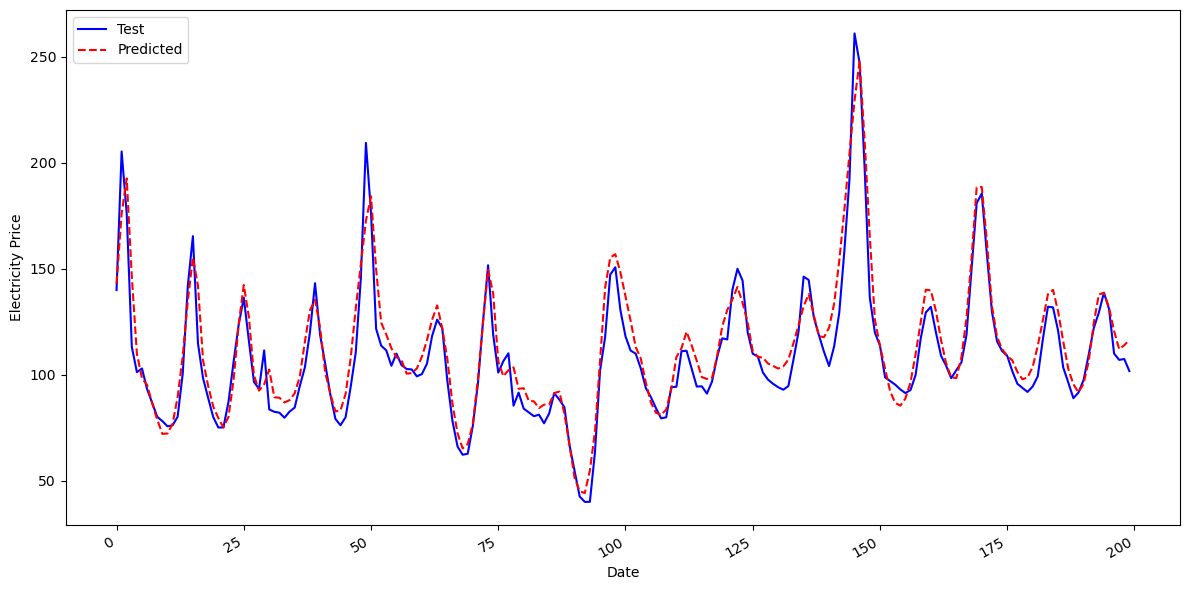

In [23]:
compare_preds(test_df_ewt['price'][24:].to_numpy().reshape(-1,1)[-200:], y_pred_sig_sum[-200:])

# Error Analysis

In [24]:
# Error on train dataset
# pred_error_train = 

In [25]:
def train_error(train_preds, real_train_data, length = 100, seq_length =24):
    # Predictions on train data
    train_preds_np = np.asarray(train_preds)
    y_train_sig_sum = np.sum(train_preds_np, axis=0).reshape(-1,1)

    # real data on train set
    real_train = real_train_data[24:].to_numpy().reshape(-1,1)
    print('Overall Performance:')
    eva_s(real_train, y_train_sig_sum)
    
    compare_preds(real_train[:length], y_train_sig_sum[:length])

    error_on_train = real_train - y_train_sig_sum

    print('\nShape of prediction errors on train data:',error_on_train.shape)
    print('Seq length:', seq_length)
    return error_on_train

In [26]:
train_preds = load_ewt_sig(MODEL, res= 'train')

Overall Performance:
Mean Absolute Error (MAE): 15.06
Root Mean Squared Error (RMSE): 20.83
Symmetric Mean Absolute Percentage Error (sMAPE): 16.63

Shape of prediction errors on train data: (17495, 1)
Seq length: 24


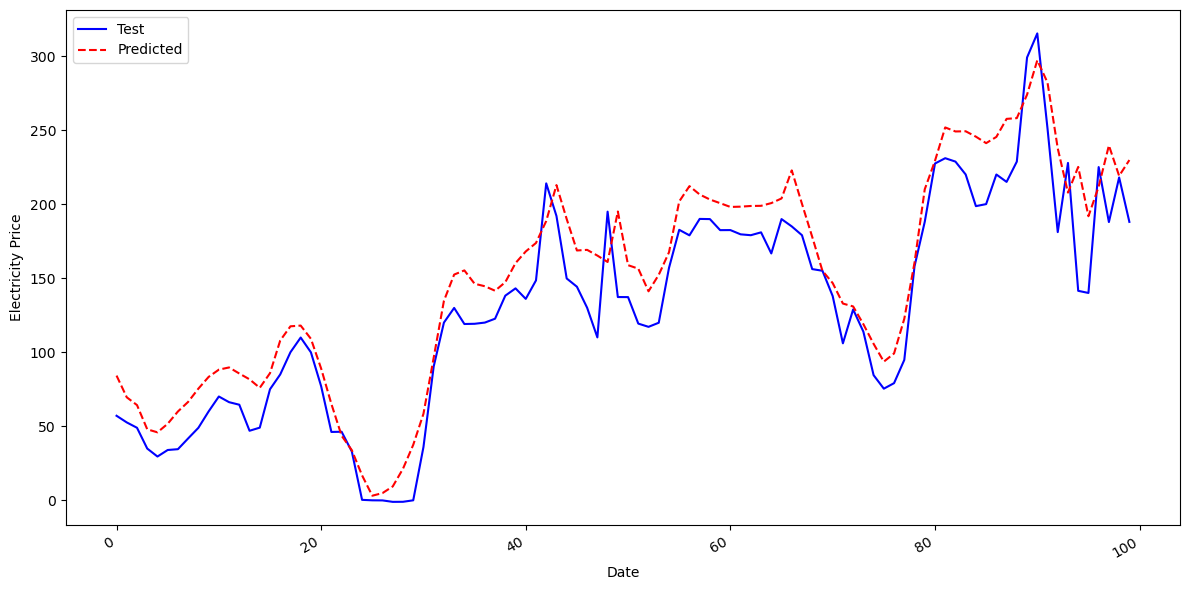

In [27]:
error_on_train = train_error(train_preds, train_df_ewt['price'])

<Figure size 1000x500 with 0 Axes>

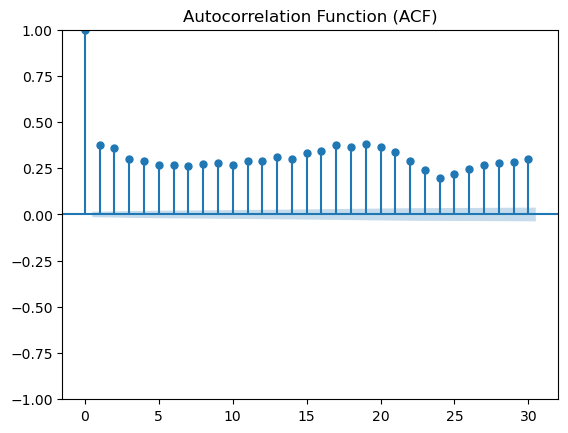

<Figure size 1000x500 with 0 Axes>

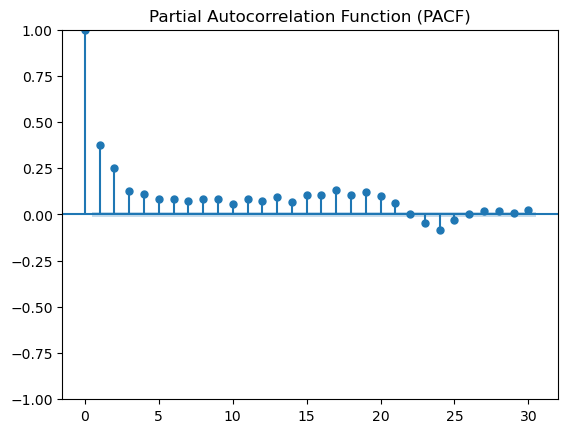

In [28]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF
plt.figure(figsize=(10, 5))
plot_acf(error_on_train, lags=30)  # Specify the number of lags
plt.title("Autocorrelation Function (ACF)")
plt.show()

# Plot PACF
plt.figure(figsize=(10, 5))
plot_pacf(error_on_train, lags=30, method='ywm')  # Specify the number of lags and method
plt.title("Partial Autocorrelation Function (PACF)")
plt.show()


In [29]:
def error_to_df(train_df, preds_error, test_df,  drop_col = ['price'], seq = SEQ):
    # Train with x y values for model training
    error_train_xy_df = train_df.drop(columns=drop_col)[SEQ:]
    error_train_xy_df['residual'] = preds_error
    
    # Test with x for test
    error_test_x_df = test_df.drop(columns=drop_col)[SEQ:]
    
    print(error_train_xy_df.info())
    print('------')
    print(error_test_x_df.info())
    
    return error_train_xy_df, error_test_x_df

In [30]:
error_train_xy_df, error_test_x_df = error_to_df(train_df_ewt, error_on_train ,test_df_ewt, drop_col = ['price'], seq = SEQ )

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17495 entries, 2022-01-02 01:00:00 to 2023-12-31 23:00:00
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   solar                    17495 non-null  int64  
 1   wind_onshore             17495 non-null  int64  
 2   wind_offshore            17495 non-null  int64  
 3   total_load               17495 non-null  int64  
 4   actual_solar             17495 non-null  int64  
 5   actual_wind_onshore      17495 non-null  int64  
 6   actual_wind_offshore     17495 non-null  int64  
 7   actual_fossil_gas        17495 non-null  int64  
 8   actual_fossil_hard_coal  17495 non-null  int64  
 9   residual                 17495 non-null  float64
dtypes: float64(1), int64(9)
memory usage: 1.5 MB
None
------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7297 entries, 2024-01-02 00:00:00 to 2024-11-01 00:00:00
Data columns (total 9 columns):
 #  

## RELM

In [31]:
error_train_xy_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17495 entries, 2022-01-02 01:00:00 to 2023-12-31 23:00:00
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   solar                    17495 non-null  int64  
 1   wind_onshore             17495 non-null  int64  
 2   wind_offshore            17495 non-null  int64  
 3   total_load               17495 non-null  int64  
 4   actual_solar             17495 non-null  int64  
 5   actual_wind_onshore      17495 non-null  int64  
 6   actual_wind_offshore     17495 non-null  int64  
 7   actual_fossil_gas        17495 non-null  int64  
 8   actual_fossil_hard_coal  17495 non-null  int64  
 9   residual                 17495 non-null  float64
dtypes: float64(1), int64(9)
memory usage: 1.5 MB


In [32]:
def renew_prect(df, renewables, target = 'total_laod'):
    for i in renewables:
        df[f'{i}_prect'] = df[i]/df['total_load']
    return df
    

In [33]:
renewables = ['wind_onshore', 'wind_offshore', 'solar']
error_train_xy_df_perct = renew_prect(error_train_xy_df, renewables, target ='total_load')

In [34]:
error_test_x_df_perct = renew_prect(error_test_x_df, renewables, target ='total_load')

In [35]:
error_test_x_df_perct.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7297 entries, 2024-01-02 00:00:00 to 2024-11-01 00:00:00
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   solar                    7297 non-null   int64  
 1   wind_onshore             7297 non-null   int64  
 2   wind_offshore            7297 non-null   int64  
 3   total_load               7297 non-null   int64  
 4   actual_solar             7297 non-null   int64  
 5   actual_wind_onshore      7297 non-null   int64  
 6   actual_wind_offshore     7297 non-null   int64  
 7   actual_fossil_gas        7297 non-null   int64  
 8   actual_fossil_hard_coal  7297 non-null   int64  
 9   wind_onshore_prect       7297 non-null   float64
 10  wind_offshore_prect      7297 non-null   float64
 11  solar_prect              7297 non-null   float64
dtypes: float64(3), int64(9)
memory usage: 741.1 KB


In [36]:
# resi_features = ['wind_onshore', 'wind_offshore', 'solar', 'total_load',  'wind_onshore_prect', 'wind_offshore_prect', 'solar_prect']
resi_features = ['wind_onshore', 'wind_offshore', 'solar', 'total_load'] 

In [37]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Step 1: Prepare the Data
# Assuming error_train_xy_df contains columns: ['residual', 'wind_onshore', 'wind_offshore', 'solar', 'total_load']
features_relm = resi_features
target = 'residual'

X = error_train_xy_df[features_relm].values
y = error_train_xy_df[target].values

# Step 2: Normalize the Data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# Step 3: Split the Data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Step 4: Implement RELM
class RELM:
    def __init__(self, n_hidden_neurons, lambda_reg):
        self.n_hidden_neurons = n_hidden_neurons
        self.lambda_reg = lambda_reg

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def fit(self, X, y):
        # Randomly initialize input weights and biases
        self.input_weights = np.random.uniform(-1, 1, (X.shape[1], self.n_hidden_neurons))
        self.biases = np.random.uniform(-1, 1, self.n_hidden_neurons)
        
        # Calculate hidden layer output matrix H
        H = self.sigmoid(np.dot(X, self.input_weights) + self.biases)
        
        # Solve for beta using regularized least squares
        I = np.eye(self.n_hidden_neurons)
        self.beta = np.linalg.inv(H.T @ H + self.lambda_reg * I) @ H.T @ y

    def predict(self, X):
        H = self.sigmoid(np.dot(X, self.input_weights) + self.biases)
        return np.dot(H, self.beta)

# Step 5: Train RELM
relm = RELM(n_hidden_neurons=20, lambda_reg=0.01)  # Adjust `n_hidden_neurons` and `lambda_reg` as needed
relm.fit(X_train, y_train)

# Step 6: Predict and Evaluate
y_pred_train = relm.predict(X_train)
y_pred_test = relm.predict(X_test)

# Inverse transform to get the original scale of the residual
y_pred_train_original = scaler_y.inverse_transform(y_pred_train.reshape(-1, 1))
y_pred_test_original = scaler_y.inverse_transform(y_pred_test.reshape(-1, 1))

# Evaluate the performance
from sklearn.metrics import mean_squared_error

y_train_orininal = scaler_y.inverse_transform(y_train.reshape(-1, 1))
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# train_rmse = np.sqrt(mean_squared_error(scaler_y.inverse_transform(y_train.reshape(-1, 1)), y_pred_train_original))
# test_rmse = np.sqrt(mean_squared_error(scaler_y.inverse_transform(y_test.reshape(-1, 1)), y_pred_test_original))

train_rmse = np.sqrt(mean_squared_error(y_train_orininal, y_pred_train_original))
test_rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_test_original))

print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")


Train RMSE: 20.13875160117615
Test RMSE: 20.192436403527264


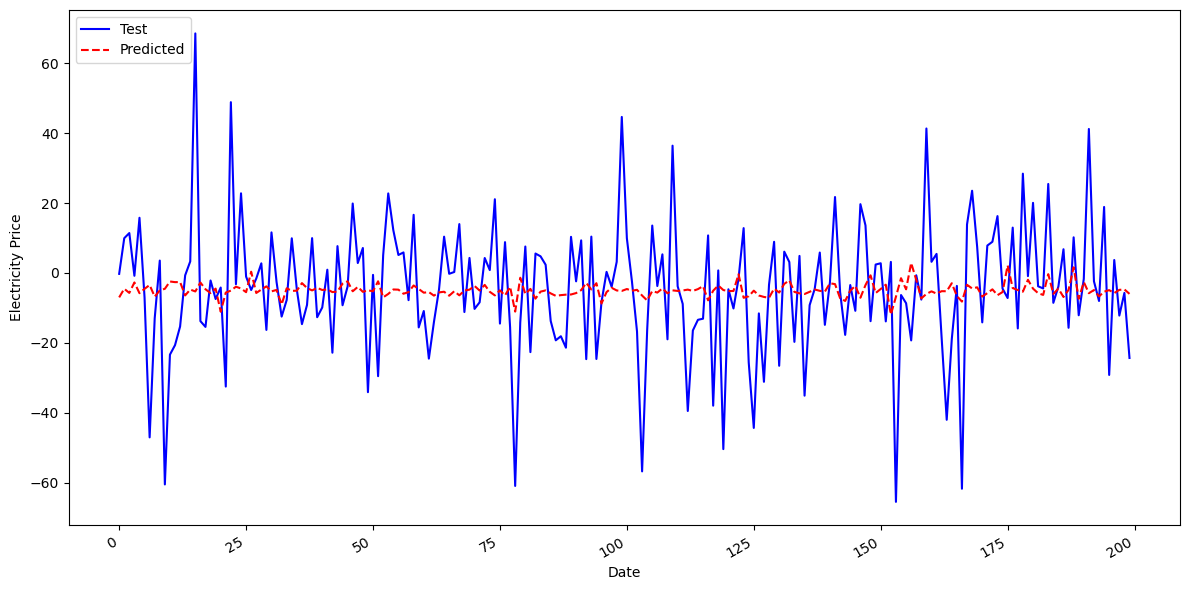

In [38]:
compare_preds(y_test_original[:200], y_pred_test_original[:200])

## Predict the residual on test data

In [39]:
# Step 1: Extract Features from the Test Dataset
# features =  error_test_x_df.columns.to_list()
features = resi_features
X_test = error_test_x_df[resi_features].values

# Step 2: Normalize Test Features using the same scaler as the training phase
X_test_scaled = scaler_X.transform(X_test)

# Step 3: Predict Residuals using the Trained RELM Model
residuals_pred_scaled = relm.predict(X_test_scaled)

# Step 4: Inverse Transform the Predicted Residuals to Original Scale
residuals_pred_original = scaler_y.inverse_transform(residuals_pred_scaled.reshape(-1,1))

# Step 5: Add Predicted Residuals to Original Model Predictions (Optional)
# Assuming `original_predictions` are predictions from the first model
# final_predictions = original_predictions + residuals_pred_original


In [49]:
def updated_preds(pred_residual, prev_preds, y_test):
    updated_preds = prev_preds + pred_residual 
    # print('Previous')
    metrics_baseline = eva_s(y_test, prev_preds)
    print('----------')
    metrics_updated = eva_s(y_test, updated_preds)
    # print('complete')
    promo_prect(metrics_baseline, metrics_updated)

In [50]:
updated_preds(residuals_pred_original, y_pred_sig_sum, y_test_1d)

Mean Absolute Error (MAE): 9.17
Root Mean Squared Error (RMSE): 11.68
Symmetric Mean Absolute Percentage Error (sMAPE): 25.08
----------
Mean Absolute Error (MAE): 7.04
Root Mean Squared Error (RMSE): 9.85
Symmetric Mean Absolute Percentage Error (sMAPE): 22.21
[23.19351372 15.66592538 11.4507592 ]


## Stat test

In [66]:
y_test_1d.reshape(-1).shape

(7297,)

In [46]:
y_pred_sig_sum.shape

(7297, 1)

In [47]:
residuals_pred_original.shape

(7297, 1)

In [92]:
dm_test_cus(y_test_1d.reshape(-1) , y_pred_sig_sum.reshape(-1), residuals_pred_original.reshape(-1) + y_pred_sig_sum.reshape(-1))

dm_return(DM=33.643771821799064, p_value=8.212701477926836e-231)

LSTM

Mean Absolute Error (MAE): 9.55

Root Mean Squared Error (RMSE): 12.09

Symmetric Mean Absolute Percentage Error (sMAPE): 25.69

----------

Mean Absolute Error (MAE): 7.21

Root Mean Squared Error (RMSE): 10.11

Symmetric Mean Absolute Percentage Error (sMAPE): 22.73

[24.47761104 16.33073214 11.51768723]

GRU

Mean Absolute Error (MAE): 9.17

Root Mean Squared Error (RMSE): 11.68

Symmetric Mean Absolute Percentage Error (sMAPE): 25.08

----------

Mean Absolute Error (MAE): 7.04

Root Mean Squared Error (RMSE): 9.85

Symmetric Mean Absolute Percentage Error (sMAPE): 22.21

[23.19351372 15.66592538 11.4507592 ]

## SVM

In [79]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

# Step 1: Prepare the data
features = ['wind_onshore', 'wind_offshore', 'solar', 'total_load']
target = 'residual'

X = error_train_xy_df[features].values  # Features
y = error_train_xy_df[target].values   # Residuals

# Step 2: Normalize the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# Step 3: Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Step 4: Train an SVM Regressor
svm = SVR(kernel='rbf', C=1.0, epsilon=0.1)  # Adjust hyperparameters as needed
svm.fit(X_train, y_train)

# Step 5: Predict residuals
y_pred_scaled = svm.predict(X_test)

# Step 6: Inverse transform predictions to the original scale
y_pred_original = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))

# # Step 7: Combine with the original model's predictions
# # Assuming `original_predictions` are the predictions from the first model
# final_predictions = original_predictions + y_pred_original

# # Step 8: Evaluate the performance
# test_rmse = np.sqrt(mean_squared_error(scaler_y.inverse_transform(y_test), y_pred_original))
# print(f"Test RMSE: {test_rmse}")


In [80]:
# Step 1: Extract Features from the Test Dataset
# features =  error_test_x_df.columns.to_list()
# features = resi_features
X_test = error_test_x_df[features].values

# Step 2: Normalize Test Features using the same scaler as the training phase
X_test_scaled = scaler_X.transform(X_test)

# Step 3: Predict Residuals using the Trained RELM Model
residuals_pred_scaled = svm.predict(X_test_scaled)

# Step 4: Inverse Transform the Predicted Residuals to Original Scale
residuals_pred_original = scaler_y.inverse_transform(residuals_pred_scaled.reshape(-1,1))

# Step 5: Add Predicted Residuals to Original Model Predictions (Optional)
# Assuming `original_predictions` are predictions from the first model
# final_predictions = original_predictions + residuals_pred_original


In [81]:
updated_preds(residuals_pred_original, y_pred_sig_sum, y_test_1d)

Mean Absolute Error (MAE): 9.55
Root Mean Squared Error (RMSE): 12.09
Symmetric Mean Absolute Percentage Error (sMAPE): 25.69
----------
Mean Absolute Error (MAE): 7.37
Root Mean Squared Error (RMSE): 10.21
Symmetric Mean Absolute Percentage Error (sMAPE): 22.85
[22.87137894 15.53812804 11.05126971]


In [56]:
adj_preds = residuals_pred_original + y_pred_sig_sum

In [57]:
resi_new = y_test_1d - adj_preds 

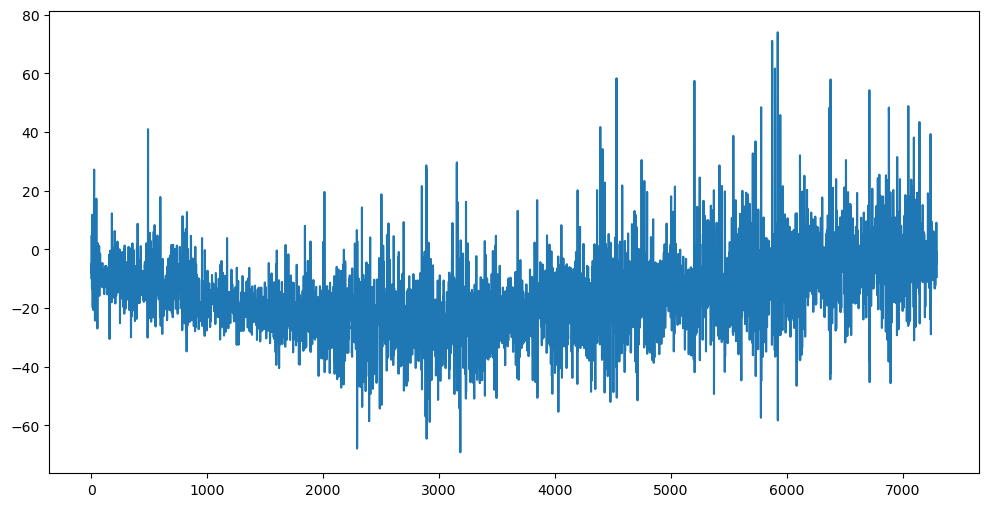

In [58]:
plt.figure(figsize=(12,6))
plt.plot(resi_new)

## Random Forest

In [82]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import numpy as np

# Step 1: Prepare the data
features = ['wind_onshore', 'wind_offshore', 'solar', 'total_load']
target = 'residual'

X = error_train_xy_df[features].values  # Features
y = error_train_xy_df[target].values   # Residuals

# Step 2: Normalize the features (Optional for Random Forest)
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

# Step 3: Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Step 4: Train the Random Forest Regressor
rf = RandomForestRegressor(n_estimators=300, max_depth=30, random_state=42)  # Adjust hyperparameters as needed
rf.fit(X_train, y_train)

# Step 5: Predict the residuals for the test set
y_pred_rf = rf.predict(X_test)

# # Step 6: Combine predicted residuals with original model's predictions
# # Assuming `original_predictions` are the predictions from the first model
# final_predictions = original_predictions + y_pred

# # Step 7: Evaluate the performance
# rmse = np.sqrt(mean_squared_error(y_test, y_pred))
# print(f"Test RMSE: {rmse}")


In [83]:
# Step 1: Extract Features from the Test Dataset
# features =  error_test_x_df.columns.to_list()
# features = resi_features
X_test = error_test_x_df[features].values

# Step 2: Normalize Test Features using the same scaler as the training phase
X_test_scaled = scaler_X.transform(X_test)

# Step 3: Predict Residuals using the Trained RELM Model
residuals_pred_scaled = rf.predict(X_test_scaled)



In [61]:
# Extract feature importances
feature_importances = rf.feature_importances_

# Display in a DataFrame
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(importance_df)

         Feature  Importance
3     total_load    0.283138
1  wind_offshore    0.273964
0   wind_onshore    0.273035
2          solar    0.169864


In [ ]:
import shap
# Create a SHAP explainer
explainer = shap.TreeExplainer(rf)
# Compute SHAP values for the dataset
shap_values = explainer.shap_values(X_test)

In [84]:
updated_preds(residuals_pred_original, y_pred_sig_sum, y_test_1d)

Mean Absolute Error (MAE): 9.55
Root Mean Squared Error (RMSE): 12.09
Symmetric Mean Absolute Percentage Error (sMAPE): 25.69
----------
Mean Absolute Error (MAE): 7.37
Root Mean Squared Error (RMSE): 10.21
Symmetric Mean Absolute Percentage Error (sMAPE): 22.85
[22.87137894 15.53812804 11.05126971]


## Decompose features

In [ ]:
sig_comps_windon = ewt_trans(error_train_xy_df['wind_onshore'], level = 6, lengthFilter= 1, reg = 'none', sigmaFilter=5)

In [ ]:
import pandas as pd

# def ewt_decompose(series, n_modes=5):
#     """
#     Decomposes a single time series into sub-bands using EWT.
    
#     Parameters:
#     - series: array-like, shape (n_samples,)
#       The input time series to decompose.
#     - n_modes: int, default=5
#       The number of modes (sub-bands) to extract.
    
#     Returns:
#     - imfs: array-like, shape (n_samples, n_modes)
#       The decomposed sub-bands.
#     """
#     # Example implementation for EWT decomposition
#     # Replace this with your actual EWT implementation
#     import numpy as np
#     from PyEMD import EMD  # Example using Empirical Mode Decomposition
#     emd = EMD()
#     imfs = emd(series)
#     return imfs[:, :n_modes]  # Limit to `n_modes` if needed

# def ewt_decompose(data, K=6, log = 0, detect = "locmax", completion = 0, reg = 'none', lengthFilter = 1,sigmaFilter = 0):

def add_ewt_features(dataframe, features, n_modes=5):
    """
    Decomposes selected features in the dataframe using EWT and adds decomposed sub-bands as new features.
    
    Parameters:
    - dataframe: pd.DataFrame
      The input dataframe containing the features to decompose.
    - features: list of str
      The names of the columns to decompose.
    - n_modes: int, default=5
      The number of modes (sub-bands) to extract for each feature.
    
    Returns:
    - dataframe: pd.DataFrame
      The dataframe with the decomposed sub-bands added as new columns.
    """
    for feature in features:
        print(f"Decomposing feature: {feature}")
        # Apply EWT decomposition
        _, imfs = ewt_decompose(dataframe[feature].values, K=n_modes, log = 0, detect = "locmax", completion = 0, reg = 'none', lengthFilter = 1,sigmaFilter = 0)

        # print(len(imfs))
        # Add each sub-band as a new feature
        for i in range(imfs.shape[1]):
            new_column_name = f"{feature}_ewt_mode_{i+1}"
            dataframe[new_column_name] = imfs[:, i]
    
    return dataframe


# Example Usage
# Assuming `df` is your dataframe and you want to decompose 4 features
features_to_decompose = ['wind_onshore', 'wind_offshore', 'solar', 'total_load']
n_modes = 6  # Number of sub-bands to extract

# Add EWT-decomposed features to the dataframe
df_with_ewt = add_ewt_features(error_train_xy_df, features_to_decompose, n_modes=n_modes)

# Check the updated dataframe
# print(df_with_ewt.head())


In [ ]:
error_test_with_ewt = add_ewt_features(error_test_x_df, features_to_decompose, n_modes=n_modes)

In [ ]:
df_with_ewt.info()

In [ ]:
ewt_features = df_with_ewt.columns.to_list()
ewt_features.remove('residual')
ewt_features

In [ ]:
import pandas as pd
import numpy as np

# 1. Prepare the Data
# Assuming 'df_with_ewt' is your dataframe with EWT-decomposed features
# And 'residual' is the target variable in your dataframe

# Select features (exclude non-numeric columns and the target variable)
X = df_with_ewt.drop(columns=['residual']).values
y = df_with_ewt['residual'].values

# 2. Split the Data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 3. Scale the Data
from sklearn.preprocessing import StandardScaler

# Scale features
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Scale target variable
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()

# 4. Train the SVR Model
from sklearn.svm import SVR

svr = SVR(kernel='rbf', C=10.0, epsilon=0.1)  # Hyperparameters to tune
svr.fit(X_train_scaled, y_train_scaled)

# 5. Predict and Evaluate
# Predict on the test set
y_pred_scaled = svr.predict(X_test_scaled)

# Inverse transform the predictions
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))

# Evaluate the model
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"SVR Mean Squared Error: {mse}")
print(f"SVR Mean Absolute Error: {mae}")


In [ ]:
compare_preds(y_test[-300:],y_pred[-300:])

In [ ]:
# Step 1: Extract Features from the Test Dataset
# features =  error_test_x_df.columns.to_list()
# features = resi_features
X_test = error_test_with_ewt[ewt_features].values

# Step 2: Normalize Test Features using the same scaler as the training phase
X_test_scaled = scaler_X.transform(X_test)

# Step 3: Predict Residuals using the Trained RELM Model
residuals_pred_scaled = svr.predict(X_test_scaled)

# Step 4: Inverse Transform the Predicted Residuals to Original Scale
residuals_pred_original = scaler_y.inverse_transform(residuals_pred_scaled.reshape(-1,1))

# Step 5: Add Predicted Residuals to Original Model Predictions (Optional)
# Assuming `original_predictions` are predictions from the first model
# final_predictions = original_predictions + residuals_pred_original

In [ ]:
updated_preds(residuals_pred_original, y_pred_sig_sum, y_test_1d)